In [151]:
%config Completer.use_jedi = False

In [155]:
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import os
import random
import unicodedata

In [156]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import  EarlyStopping

In [161]:
path  = './data/namesbystate/'
list_files = os.listdir(path)

In [162]:
state_df = []
for file in list_files:
    if '.TXT' not in file:
        continue
    df = pd.read_csv(path + file, index_col=False, header=None, names=['state', 'gender', 'year', 'name', 'freq'])
    state_df.append( df )

In [163]:
df_us = pd.concat( state_df )
df_us.reset_index(drop=True)

,state,gender,year,name,freq
0,IN,F,1910,Mary,619
1,IN,F,1910,Helen,324
2,IN,F,1910,Ruth,238
3,IN,F,1910,Dorothy,215
4,IN,F,1910,Mildred,200
...,...,...,...,...,...
6122885,DE,M,2019,River,5
6122886,DE,M,2019,Rocco,5
6122887,DE,M,2019,Shane,5
6122888,DE,M,2019,Syncere,5


In [167]:
df_us.to_csv('./data/us_gender.csv',index=None)

In [180]:
df_male = df_us[ df_us.gender == 'M' ].copy()
df_female = df_us[ df_us.gender == 'F' ].copy()

In [190]:
ls_male = list( df_male.name.unique())
ls_female = list( df_female.name.unique())

In [184]:
print('Ratio male-female ', len(ls_male)/len(ls_female))

Ratio male-female  0.662322838390564


In [199]:
ls_gender = [0]*len(ls_male) + [1]*len(ls_female)
ls_name   = ls_male + ls_female
df = pd.DataFrame( {'gender':ls_gender, 'name':ls_name})
df = df.sample(frac=1).reset_index(drop=True)
df.name =  df.name.map( lambda x: x.lower())

In [200]:
def get_alphabet(df):
    # list of unique letters
    alphabet = []
    for name in df.name:
        alphabet.extend( list(name))
        
    return set(alphabet)    

In [201]:
alphabet = set(get_alphabet(df))

In [203]:
word_vec_length = df.name.apply(len).max()
char_vec_length = len(alphabet)
output_labels   = 2

print(f"The input vector will have the shape {word_vec_length}x{char_vec_length}.")

The input vector will have the shape 15x26.


In [204]:
# Define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


# Returns a list of n lists with n = word_vec_length
def name_encoding(name):
    # Encode input data to int, e.g. a->1, z->26
    integer_encoded = [ char_to_int[char] for char in name]
    
    # Start one-hot-encoding
    onehot_encoded = list()
    
    for value in integer_encoded:
        # create a list of n zeros, where n is equal to the number of accepted characters
        letter = [0 for _ in range(char_vec_length)]
        letter[value] = 1
        onehot_encoded.append(letter)
        
    # Fill up list to the max length. Lists need do have equal length to be able to convert it into an array
    for _ in range(word_vec_length - len(name)):
        onehot_encoded.append([0 for _ in range(char_vec_length)])
        
    return onehot_encoded


# Encode the output labels
def label_binary_encoding(gender_series):
    labels = np.empty((0, 2))
    for n in gender_series:
        x = [1,0] if n == 0 else [0,1]
        labels = np.append(labels, [x], axis=0)
    return labels

# Encode the output labels
def label_encoding(gender_series):
    labels = np.empty((0, 3))
    for n in gender_series:
        x = [0,0,0]
        x[n] = 1        
        labels = np.append(labels, [x], axis=0)
    return labels

In [205]:
train, test = np.split(df.sample(frac=1), [int(.8*len(df))])

# Convert both the input names as well as the output lables into the discussed machine readable vector format
train_x =  np.asarray([np.asarray(name_encoding(name)) for name in train.name])
train_y = label_binary_encoding(train.gender)

test_x = np.asarray([name_encoding(name) for name in test.name])
test_y = label_binary_encoding(test.gender)

In [206]:
hidden_nodes = int(2/3 * (word_vec_length * char_vec_length))
#print(f"The number of hidden nodes is {hidden_nodes}.")

In [211]:
model = Sequential()
model.add(LSTM( hidden_nodes, return_sequences=False, input_shape=(word_vec_length, char_vec_length)))
model.add(Dropout(0.2))

model.add(Dense( units= hidden_nodes//2 ))
model.add(Dropout(0.2))

model.add(Dense(units=output_labels))

model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 260)               298480    
_________________________________________________________________
dropout_13 (Dropout)         (None, 260)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 130)               33930     
_________________________________________________________________
dropout_14 (Dropout)         (None, 130)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 262       
_________________________________________________________________
activation_9 (Activation)    (None, 2)                 0         
Total params: 332,672
Trainable params: 332,672
Non-trainable params: 0
________________________________________________

In [212]:
callbacks = [ EarlyStopping(  monitor='val_loss', mode='min'  ) ]

In [213]:
history = model.fit(train_x, train_y, batch_size=256, epochs=20, validation_data=(test_x, test_y)) #callbacks=callbacks

Epoch 1/20
110/110 [==============================] - 16s 127ms/step - loss: 0.6062 - acc: 0.6688 - val_loss: 0.5633 - val_acc: 0.7111
Epoch 2/20
110/110 [==============================] - 14s 123ms/step - loss: 0.5428 - acc: 0.7289 - val_loss: 0.5283 - val_acc: 0.7445
Epoch 3/20
110/110 [==============================] - 14s 125ms/step - loss: 0.5239 - acc: 0.7476 - val_loss: 0.5145 - val_acc: 0.7462
Epoch 4/20
110/110 [==============================] - 14s 124ms/step - loss: 0.5095 - acc: 0.7551 - val_loss: 0.5100 - val_acc: 0.7501
Epoch 5/20
110/110 [==============================] - 13s 122ms/step - loss: 0.4925 - acc: 0.7666 - val_loss: 0.4931 - val_acc: 0.7710
Epoch 6/20
110/110 [==============================] - 14s 126ms/step - loss: 0.4740 - acc: 0.7753 - val_loss: 0.4774 - val_acc: 0.7767
Epoch 7/20
110/110 [==============================] - 15s 135ms/step - loss: 0.4694 - acc: 0.7785 - val_loss: 0.4705 - val_acc: 0.7771
Epoch 8/20
110/110 [==============================] - 1

<AxesSubplot:>

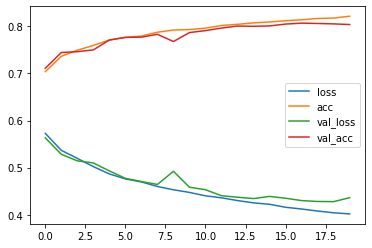

In [214]:
sdf = pd.DataFrame(history.history)
sdf.plot()

In [215]:
from sklearn.metrics import confusion_matrix

In [216]:
y_pred =  [0 if p[0] > p[1] else 1 for p in model.predict(test_x)]

In [217]:
confusion_matrix( test.gender.values, y_pred)

array([[2146,  666],
       [ 705, 3474]])